In [16]:
import sys, time
from pathlib import Path
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ── 1) Identify project root (one level up from this notebook) ────────────────
project_root = Path.cwd().parent
print(f"Project root → {project_root}")
# ── 2) Add your brute‐force helper scripts to the path ────────────────────────
brute_scripts = project_root/"4_brute"/"4_brute_scripts"
assert brute_scripts.exists(), f"Can't find scripts at {brute_scripts}"
sys.path.insert(0, str(brute_scripts))
print(f"Added to path → {brute_scripts}")
# ── 3) Import only from 4_brute_scripts ───────────────────────────────────────
from pv_simulate_30    import simulate_multi_year_pv
from battery_30        import simulate_battery_dispatch
from financial_30      import compute_financials
print("✅ Imports successful – ready to run brute force!")

Project root → /Users/petertunali/Documents/GitHub/Battery_Optimisation
Added to path → /Users/petertunali/Documents/GitHub/Battery_Optimisation/4_brute/4_brute_scripts
✅ Imports successful – ready to run brute force!


In [17]:
# Cell 2: Simplified clean data loading
import pandas as pd

def load_demand_profile(csv_path: Path) -> pd.Series:
    # Load the CSV and skip NaN timestamp rows immediately
    raw = pd.read_csv(csv_path, parse_dates=['Date and Time'], dayfirst=True)
    
    # Drop rows with NaN timestamps right away
    raw = raw.dropna(subset=['Date and Time'])
    print(f"CSV loaded with {len(raw)} valid rows")
    
    # Get the consumption column
    consumption_col = 'Consumtpion (kWh)'  # Based on your data sample
    
    # Create a Series with timestamp index and consumption values
    s = pd.Series(raw[consumption_col].values, index=raw['Date and Time'])
    
    # Check for duplicate timestamps
    dup_count = s.index.duplicated().sum()
    if dup_count:
        print(f"⚠️ Dropping {dup_count} duplicate timestamps")
        s = s[~s.index.duplicated(keep='first')]
    
    # Build the expected half-hour index for entire year (no Feb 29)
    year = s.index.min().year
    start = pd.Timestamp(year, 1, 1, 0, 0)
    end = pd.Timestamp(year, 12, 31, 23, 30)
    expected = pd.date_range(start, end, freq="30min")
    expected = expected[~((expected.month==2) & (expected.day==29))]
    
    # Reindex to ensure complete coverage
    s = s.reindex(expected)
    missing = s.isna().sum()
    if missing:
        print(f"⚠️ Filling {missing} missing points with 0")
        s = s.fillna(0.0)
    
    # Final sanity check
    assert len(s) == 17520, f"Got {len(s)} points, expected 17520"
    return s

# Load one-year demand data
demand_csv = project_root/"data"/"PV_Generation_excel.csv"
print(f"Loading demand data from: {demand_csv}\n")
one_year_dem = load_demand_profile(demand_csv)
print(f"One year data points: {len(one_year_dem)}")

# Create a proper date range for 30 years with no leap days
start_year = one_year_dem.index[0].year
years = 30
all_data = []

# Build 30 years of data year by year
for year_offset in range(years):
    # Copy the data for this year
    year_data = one_year_dem.copy()
    
    # Create index for this specific year
    year_start = pd.Timestamp(start_year + year_offset, 1, 1, 0, 0)
    year_end = pd.Timestamp(start_year + year_offset, 12, 31, 23, 30)
    year_range = pd.date_range(start=year_start, end=year_end, freq="30min")
    
    # Remove Feb 29 if it's a leap year
    year_range = year_range[~((year_range.month == 2) & (year_range.day == 29))]
    
    # Make sure it has the right number of points
    assert len(year_range) == len(one_year_dem), f"Year {start_year + year_offset} has {len(year_range)} points, expected {len(one_year_dem)}"
    
    # Assign the new index and add to our list
    year_data.index = year_range
    all_data.append(year_data)

# Concatenate all years
demand_profile = pd.concat(all_data)

print("✅ Demand profile built:", len(demand_profile), "steps")
print(f"Date range: {demand_profile.index[0]} to {demand_profile.index[-1]}")

Loading demand data from: /Users/petertunali/Documents/GitHub/Battery_Optimisation/data/PV_Generation_excel.csv

CSV loaded with 17520 valid rows
One year data points: 17520
✅ Demand profile built: 525600 steps
Date range: 2025-01-01 00:00:00 to 2054-12-31 23:30:00


In [19]:
# Cell 3: Build PV Unit & Baseline Cost
# weather files & orientation
weather_files = [
    str(project_root/"data"/fn)
    for fn in ["Bonfire_2025.epw","Bonfire_2040_4_5.epw","Bonfire_2050_4_5.epw"]
]
roof = {'system_capacity_kw':1.0, 'tilt':30.0, 'azimuth':5.0}
# 1 kW unit profile over 30 yr
pv_unit = simulate_multi_year_pv(
    weather_files=weather_files,
    roof_params=[roof],
    repeats_per_file=10,
    start_years=[2025,2040,2050]
)['simulated_kwh']
# drop any Feb 29 across 30 yr
pv_unit = pv_unit[~((pv_unit.index.month==2)&(pv_unit.index.day==29))]
print("PV unit profile length:", len(pv_unit))
# baseline import cost with zero storage
disp0, tots0 = simulate_battery_dispatch(
    pv_unit*0, 
    demand_profile, 
    battery_kwh=0.0,
    roundtrip_eff=0.9,    # 90% round-trip efficiency
    min_soc_pct=0.05,     # 95% depth of discharge 
    annual_deg_rate=0.01,
    grid_emission_rate=0.81  # Updated emission factor
)
fin0 = compute_financials(
    tots0, 
    battery_kwh=0, 
    pv_kw=0, 
    discount_rate=0.07
)
BASE_IMPORT_COST = fin0['import_cost_total']
print("Baseline import cost:", BASE_IMPORT_COST)

Using 'PV Generated (kWh)' from original data

Original PV unit start timestamp: 2025-01-01 00:00:00
Original PV unit first 5 timestamps:
  2025-01-01 00:00:00: 0.0000 kWh
  2025-01-01 00:30:00: 0.0000 kWh
  2025-01-01 01:00:00: 0.0000 kWh
  2025-01-01 01:30:00: 0.0000 kWh
  2025-01-01 02:00:00: 0.0000 kWh

PV unit profile length before reindexing: 525264
Demand profile start timestamp: 2025-01-01 00:00:00
Demand profile first 5 timestamps:
  2025-01-01 00:00:00: 2.6110 kWh
  2025-01-01 00:30:00: 2.7150 kWh
  2025-01-01 01:00:00: 1.8840 kWh
  2025-01-01 01:30:00: 0.0000 kWh
  2025-01-01 02:00:00: 0.0000 kWh

PV unit profile length after reindexing: 525600

=== First 24 Hours Comparison (Jan 1, 2025) ===
                Date   Hour  Simulated PV (kWh)  Demand (kWh)  Original PV Data (kWh)
0   2025-01-01 00:00  00:00            0.000000       2.61100                0.000000
1   2025-01-01 00:30  00:30            0.000000       2.71500                0.000000
2   2025-01-01 01:00  01:00  

In [21]:
# Cell 4: Define Sweep & Run Brute-Force with Optimized Ranges
import numpy as np
import pandas as pd
import time
from datetime import timedelta
from tqdm.notebook import tqdm  # For Jupyter notebook progress bar

# Sequential simulation function
def run_sweep(pv_sizes, batt_sizes, pv_unit, demand_profile, BASE_IMPORT_COST):
    total_sims = len(pv_sizes) * len(batt_sizes)
    print(f"Running {total_sims} simulations sequentially with progress tracking...")
    
    results = []
    idx = 0
    
    # Create a progress bar
    pbar = tqdm(total=total_sims)
    
    start = time.time()
    for pv_kw in pv_sizes:
        prof = pv_unit * pv_kw
        for batt in batt_sizes:
            idx += 1
            
            # Run simulation with updated battery parameters
            _, tots = simulate_battery_dispatch(
                prof, 
                demand_profile, 
                battery_kwh=batt,
                battery_kw=batt * 0.5,  # Discharge rate of 0.5C
                roundtrip_eff=0.9,      # Round trip efficiency of 0.9
                min_soc_pct=0.05,       # Depth of discharge 95%
                annual_deg_rate=0.01,   # Degradation rate of 1%
                grid_emission_rate=0.81 # Grid emissions 0.81 kg CO2e/kWh
            )
            
            # Run financial calculation with updated parameters
            fin = compute_financials(
                tots,
                battery_kwh=batt,
                pv_kw=pv_kw,
                discount_rate=0.07,
                baseline_import_cost=BASE_IMPORT_COST
            )
            
            results.append({
                'pv_kw': pv_kw,
                'battery_kwh': batt,
                'IRR': fin['irr'],
                'NPC': fin['net_cost'],
                'pv_cost_per_kw': fin.get('pv_cost_per_kw', 0),
                'battery_cost_per_kwh': fin.get('battery_cost_per_kwh', 0),
                'battery_total_cycles': fin.get('battery_total_cycles', 0),
                'battery_final_degradation_pct': fin.get('battery_final_degradation_pct', 0)
            })
            
            # Update progress bar every 10 simulations
            if idx % 10 == 0:
                pbar.update(10)
            elif idx == total_sims:
                pbar.update(total_sims % 10)
            
            # Report ETA occasionally
            if idx % 50 == 0 or idx == total_sims:
                elapsed = time.time() - start
                eta = (elapsed / idx) * (total_sims - idx)
                print(f"{idx}/{total_sims} ({idx/total_sims*100:.1f}%) – ETA: {timedelta(seconds=int(eta))}", end="\r")
    
    pbar.close()
    print(f"\nDone in {timedelta(seconds=int(time.time()-start))}")
    return results

# Optimized sweep ranges - finer granularity
pv_sizes = np.arange(0, 101, 1.0)    # 0–100 kW by 1 kW (101 values)
batt_sizes = np.arange(0, 201, 2)    # 0–200 kWh by 2 kWh (101 values)

# Run the simulations
results = run_sweep(pv_sizes, batt_sizes, pv_unit, demand_profile, BASE_IMPORT_COST)

Running 10201 simulations sequentially with progress tracking...


  0%|          | 0/10201 [00:00<?, ?it/s]

10201/10201 (100.0%) – ETA: 0:00:00
Done in 4:18:31


Best → PV 11.0 kW, Batt 0.0 kWh, IRR 10.6%

Simulating best solution for detailed 30-year time series...
Saving full 30-year time series data...
Saved 30-year time series to /Users/petertunali/Documents/GitHub/Battery_Optimisation/4_brute/4_brute_outputs/01/best_solution_30yr_timeseries.csv
Saved data dictionary to /Users/petertunali/Documents/GitHub/Battery_Optimisation/4_brute/4_brute_outputs/01/data_dictionary.csv
Saved comprehensive summary to /Users/petertunali/Documents/GitHub/Battery_Optimisation/4_brute/4_brute_outputs/01/comprehensive_summary.csv


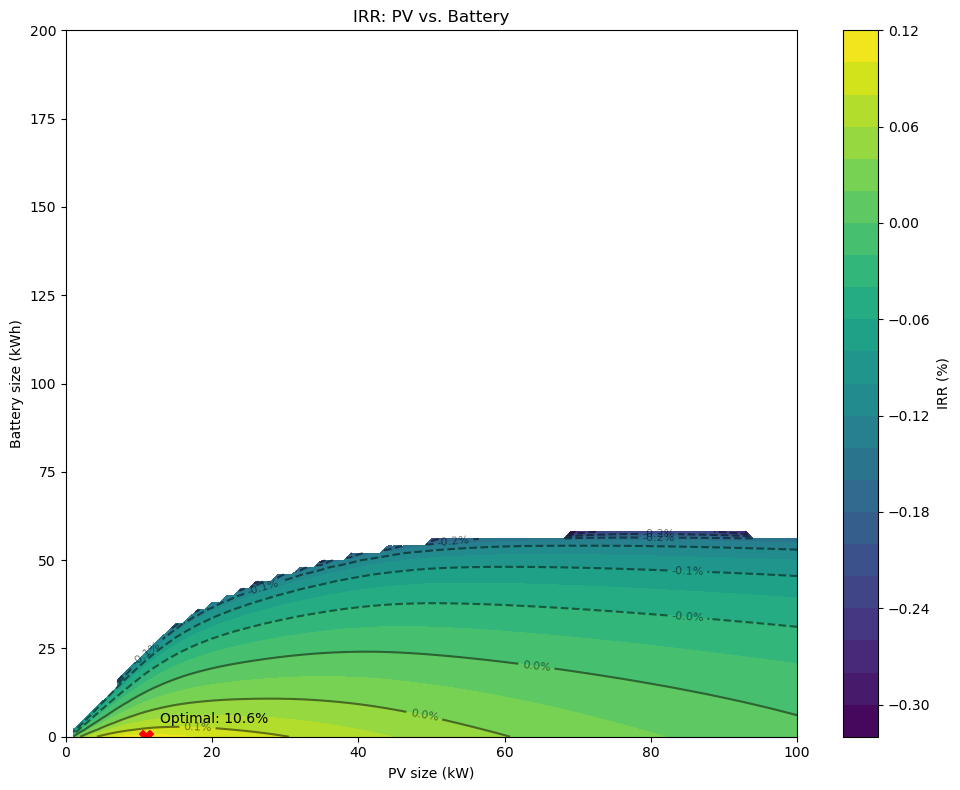

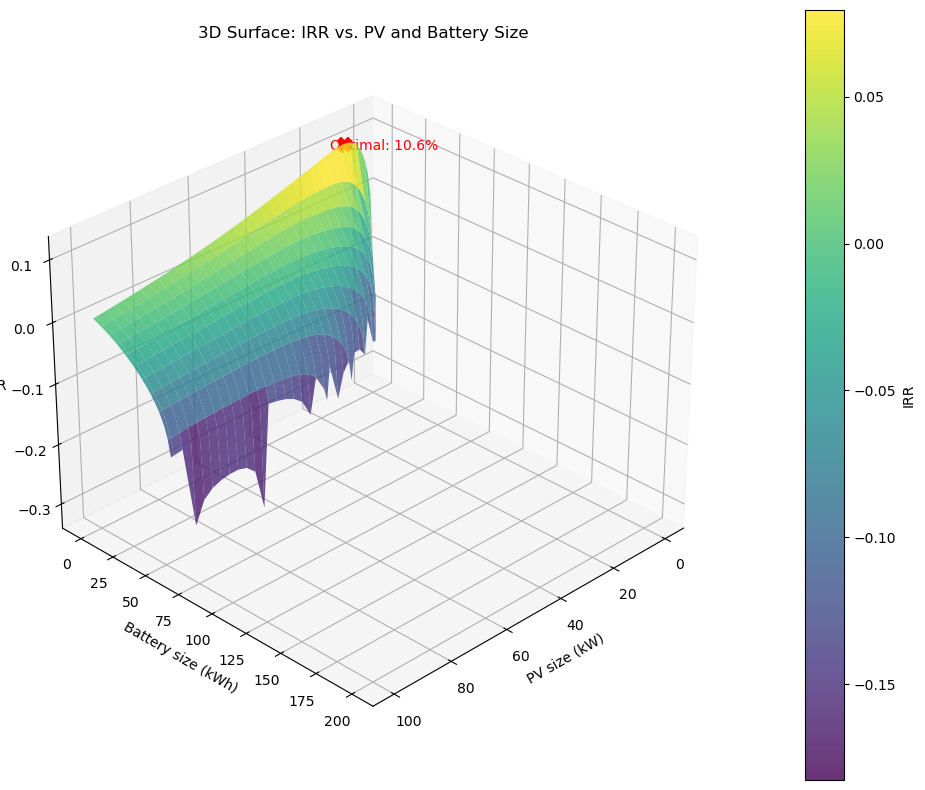

Outputs in /Users/petertunali/Documents/GitHub/Battery_Optimisation/4_brute/4_brute_outputs/01


In [24]:
# Cell 5: Save Results & Plot with Enhanced Visualization, 3D Surface, and Full Time Series
df = pd.DataFrame(results)
# auto‐version outputs
out_base = project_root/"4_brute"/"4_brute_outputs"
out_base.mkdir(exist_ok=True)
runs = [int(d.name) for d in out_base.iterdir() if d.is_dir() and d.name.isdigit()]
if not runs:
    runs = [0]
else:
    runs = sorted(runs)
run_no = runs[-1]+1 if runs else 1
out_dir = out_base/f"{run_no:02d}"
out_dir.mkdir(exist_ok=True)

# Save all results
df.to_csv(out_dir/"brute_force_results.csv", index=False)
best = df.loc[df.IRR.idxmax()]
best.to_frame().T.to_csv(out_dir/"best_solution.csv", index=False)
print(f"Best → PV {best.pv_kw} kW, Batt {best.battery_kwh} kWh, IRR {best.IRR:.1%}")

# Run the simulation again for the best solution to get detailed results
best_pv_kw = best.pv_kw
best_battery_kwh = best.battery_kwh
best_prof = pv_unit * best_pv_kw

# Get detailed dispatch results for best solution
print("\nSimulating best solution for detailed 30-year time series...")
best_disp, best_tots = simulate_battery_dispatch(
    best_prof, 
    demand_profile, 
    battery_kwh=best_battery_kwh,
    battery_kw=best_battery_kwh * 0.5,  # 0.5C rate
    roundtrip_eff=0.9,                  # 90% round-trip efficiency
    min_soc_pct=0.05,                   # 95% depth of discharge
    annual_deg_rate=0.01,               # 1% annual degradation  
    grid_emission_rate=0.81             # 0.81 kg CO2e per kWh
)

# Calculate financial metrics for the best solution in detail
best_fin = compute_financials(
    best_tots,
    battery_kwh=best_battery_kwh,
    pv_kw=best_pv_kw,
    discount_rate=0.07,
    baseline_import_cost=BASE_IMPORT_COST
)

# Save full 30-year time series to CSV
print("Saving full 30-year time series data...")
best_disp.to_csv(out_dir/"best_solution_30yr_timeseries.csv")
print(f"Saved 30-year time series to {out_dir}/best_solution_30yr_timeseries.csv")

# Create a data dictionary with variable definitions and store as CSV
data_dict = pd.DataFrame([
    {"Variable": "pv_gen", "Description": "PV generation in kWh for each half-hour", "Units": "kWh"},
    {"Variable": "demand", "Description": "Electricity demand in kWh for each half-hour", "Units": "kWh"},
    {"Variable": "pv_used", "Description": "PV generation used directly to satisfy demand", "Units": "kWh"},
    {"Variable": "battery_charge", "Description": "Energy used to charge the battery", "Units": "kWh"},
    {"Variable": "battery_discharge", "Description": "Energy discharged from the battery", "Units": "kWh"},
    {"Variable": "battery_soc", "Description": "Battery state of charge", "Units": "kWh"},
    {"Variable": "pv_export", "Description": "Excess PV generation exported to the grid", "Units": "kWh"},
    {"Variable": "grid_import_peak", "Description": "Electricity imported during peak hours", "Units": "kWh"},
    {"Variable": "grid_import_offpeak", "Description": "Electricity imported during off-peak hours", "Units": "kWh"}
])
data_dict.to_csv(out_dir/"data_dictionary.csv", index=False)
print(f"Saved data dictionary to {out_dir}/data_dictionary.csv")

# Create a comprehensive summary of all parameters and results
summary_data = {
    "Parameter": [],
    "Value": [],
    "Units": [],
    "Description": []
}

# System configuration
summary_data["Parameter"].extend(["PV Size", "Battery Size", "Battery Power", "Battery Min SOC", "Battery Round-Trip Efficiency", "Battery Degradation Rate"])
summary_data["Value"].extend([best_pv_kw, best_battery_kwh, best_battery_kwh * 0.5, 0.05, 0.9, 0.01])
summary_data["Units"].extend(["kW", "kWh", "kW", "fraction", "fraction", "fraction/year"])
summary_data["Description"].extend([
    "Optimal PV system size",
    "Optimal battery energy capacity", 
    "Battery power rating (0.5C rate)", 
    "Minimum state of charge (depth of discharge = 95%)", 
    "Round-trip efficiency (charge/discharge losses)", 
    "Annual capacity degradation rate"
])

# Cost parameters
summary_data["Parameter"].extend([
    "PV Cost per kW", "PV Installation Cost", "Battery Cost per kWh", 
    "Battery Installation Cost", "PV Maintenance", "Battery Maintenance", "Discount Rate"
])
summary_data["Value"].extend([
    best_fin["pv_cost_per_kw"], 5000.0, best_fin["battery_cost_per_kwh"], 
    174.0, 0.13, 0.12, 0.07
])
summary_data["Units"].extend(["$/kW", "$", "$/kWh", "$/kWh", "$/kW/day", "$/kW/day", "fraction"])
summary_data["Description"].extend([
    "PV system cost per kW (based on formula)",
    "Fixed PV installation cost",
    "Battery cost per kWh (based on formula)",
    "Battery installation cost per kWh",
    "Daily PV maintenance cost per kW",
    "Daily battery maintenance cost per kW",
    "Discount rate for financial calculations"
])

# Tariff parameters
summary_data["Parameter"].extend(["Peak Import Rate", "Off-Peak Import Rate", "Feed-in Tariff", "Grid Emission Rate"])
summary_data["Value"].extend([0.39710, 0.13530, 0.033, 0.81])
summary_data["Units"].extend(["$/kWh", "$/kWh", "$/kWh", "kg CO2e/kWh"])
summary_data["Description"].extend([
    "Electricity import cost during peak hours",
    "Electricity import cost during off-peak hours",
    "Rate paid for exported PV generation",
    "Grid electricity carbon intensity"
])

# Key results - energy
summary_data["Parameter"].extend([
    "Total Demand", "Total PV Generation", "Total PV Used Directly", 
    "Total Battery Discharge", "Total Grid Import (Peak)", "Total Grid Import (Off-Peak)", 
    "Total PV Export", "Renewable Fraction", "Self-Consumption Rate"
])
summary_data["Value"].extend([
    best_tots["total_demand"], best_pv_kw * pv_unit.sum(), best_tots["total_pv_used"], 
    best_tots["total_battery_discharge"], best_tots["total_grid_import_peak"], best_tots["total_grid_import_offpeak"], 
    best_tots["total_pv_export"], best_tots["renewable_fraction"], best_tots["self_consumption_rate"]
])
summary_data["Units"].extend(["kWh", "kWh", "kWh", "kWh", "kWh", "kWh", "kWh", "fraction", "fraction"])
summary_data["Description"].extend([
    "Total electricity demand over 30 years",
    "Total PV generation over 30 years",
    "Total PV generation used directly",
    "Total energy discharged from battery",
    "Total grid imports during peak hours",
    "Total grid imports during off-peak hours",
    "Total PV generation exported to grid",
    "Fraction of demand met by renewable sources (PV + battery)",
    "Fraction of PV generation used on-site (directly or via battery)"
])

# Key results - financial
summary_data["Parameter"].extend([
    "CAPEX PV", "CAPEX Battery", "CAPEX Total", "OPEX Total", 
    "Export Revenue", "Import Cost", "Baseline Import Cost", "Net Present Cost", "IRR",
    "Battery Total Cycles", "Battery Final Degradation"
])
summary_data["Value"].extend([
    best_fin["capex_pv"], best_fin["capex_battery"], best_fin["capex_total"], best_fin["opex_total"], 
    best_fin["export_revenue_total"], best_fin["import_cost_total"] + BASE_IMPORT_COST, BASE_IMPORT_COST, 
    best_fin["net_cost"], best_fin["irr"],
    best_fin.get("battery_total_cycles", 0), best_fin.get("battery_final_degradation_pct", 0)
])
summary_data["Units"].extend(["$", "$", "$", "$", "$", "$", "$", "$", "fraction", "cycles", "%"])
summary_data["Description"].extend([
    "Capital expenditure for PV system",
    "Capital expenditure for battery system",
    "Total capital expenditure",
    "Total operational expenditure over 30 years",
    "Total revenue from exported PV over 30 years",
    "Cost of grid imports with PV+battery system",
    "Cost of grid imports without PV+battery (baseline)",
    "Net present cost of the system (negative = profit)",
    "Internal rate of return",
    "Total battery charge/discharge cycles over lifetime",
    "Final battery capacity degradation percentage"
])

# Create DataFrame and save
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(out_dir/"comprehensive_summary.csv", index=False)
print(f"Saved comprehensive summary to {out_dir}/comprehensive_summary.csv")

# Enhanced contour plot of IRR
pivot = df.pivot(index="battery_kwh", columns="pv_kw", values="IRR")
plt.figure(figsize=(10,8))
cnt = plt.contourf(pivot.columns, pivot.index, pivot.values, levels=20, cmap="viridis")
contour_lines = plt.contour(pivot.columns, pivot.index, pivot.values, levels=10, colors='black', alpha=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f%%')
plt.colorbar(cnt, label="IRR (%)")

# Mark the optimal point
plt.scatter([best.pv_kw], [best.battery_kwh], color='red', marker='X', s=100)
plt.annotate(f"Optimal: {best.IRR:.1%}", 
          (best.pv_kw, best.battery_kwh), 
          xytext=(10, 10), 
          textcoords='offset points')

plt.xlabel("PV size (kW)")
plt.ylabel("Battery size (kWh)")
plt.title("IRR: PV vs. Battery")
plt.tight_layout()
plt.savefig(out_dir/"irr_contour.png", dpi=300)
plt.show()

# Create 3D surface plot of IRR
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure for 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for 3D surface
X, Y = np.meshgrid(pivot.columns, pivot.index)
Z = pivot.values

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Add color bar
cbar = fig.colorbar(surf, ax=ax, pad=0.1, label='IRR')

# Mark the optimal point
ax.scatter([best.pv_kw], [best.battery_kwh], [best.IRR], color='red', s=100, marker='X')
ax.text(best.pv_kw+5, best.battery_kwh, best.IRR, f"Optimal: {best.IRR:.1%}", color='red')

# Set labels and title
ax.set_xlabel('PV size (kW)')
ax.set_ylabel('Battery size (kWh)')
ax.set_zlabel('IRR')
ax.set_title('3D Surface: IRR vs. PV and Battery Size')

# Adjust the view angle for better visualization
ax.view_init(elev=30, azim=45)

# Save the 3D plot
plt.savefig(out_dir/"irr_surface_3d.png", dpi=300, bbox_inches='tight')
plt.show()

# Create daily profile plots for optimal solution
# Summer day
summer_date = pd.Timestamp(f"{demand_profile.index[0].year}-01-15")
summer_mask = (best_disp.index.date == summer_date.date())
summer_data = best_disp[summer_mask]

plt.figure(figsize=(12, 6))
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['pv_gen'], 'orange', label='PV Generation')
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['demand'], 'blue', label='Demand')
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['battery_discharge'], 'green', label='Battery Discharge')
plt.plot(summer_data.index.strftime('%H:%M'), summer_data['grid_import_peak'] + summer_data['grid_import_offpeak'], 'red', label='Grid Import')
plt.fill_between(summer_data.index.strftime('%H:%M'), summer_data['battery_soc'], alpha=0.3, color='green', label='Battery SOC')
plt.xticks(rotation=90)
plt.title(f'Summer Day Profile: {summer_date.strftime("%B %d")}')
plt.xlabel('Time of Day')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.savefig(out_dir/"summer_day_profile.png", dpi=300)
plt.close()

# Winter day
winter_date = pd.Timestamp(f"{demand_profile.index[0].year}-07-15")
winter_mask = (best_disp.index.date == winter_date.date())
winter_data = best_disp[winter_mask]

plt.figure(figsize=(12, 6))
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['pv_gen'], 'orange', label='PV Generation')
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['demand'], 'blue', label='Demand')
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['battery_discharge'], 'green', label='Battery Discharge')
plt.plot(winter_data.index.strftime('%H:%M'), winter_data['grid_import_peak'] + winter_data['grid_import_offpeak'], 'red', label='Grid Import')
plt.fill_between(winter_data.index.strftime('%H:%M'), winter_data['battery_soc'], alpha=0.3, color='green', label='Battery SOC')
plt.xticks(rotation=90)
plt.title(f'Winter Day Profile: {winter_date.strftime("%B %d")}')
plt.xlabel('Time of Day')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.savefig(out_dir/"winter_day_profile.png", dpi=300)
plt.close()

# Save additional details about the best solution
with open(out_dir/"best_solution_details.txt", "w") as f:
    f.write(f"Best Solution Details:\n")
    f.write(f"PV Size: {best.pv_kw:.1f} kW\n")
    f.write(f"Battery Size: {best.battery_kwh:.1f} kWh\n")
    f.write(f"IRR: {best.IRR:.2%}\n")
    f.write(f"Net Present Cost: ${best.NPC:.2f}\n")
    f.write(f"\nSimulation Parameters:\n")
    f.write(f"PV Cost: ${best_fin['pv_cost_per_kw']:.2f}/kW + $5000 installation\n")
    f.write(f"Battery Cost: ${best_fin['battery_cost_per_kwh']:.2f}/kWh + $174/kWh installation\n")
    f.write(f"PV Maintenance: $0.13/kW/day\n")
    f.write(f"Battery Maintenance: $0.12/kW/day\n")
    f.write(f"Discount Rate: 7%\n")
    f.write(f"Battery Degradation: 1%/year\n")
    f.write(f"Battery Depth of Discharge: 95%\n")
    f.write(f"Battery Round Trip Efficiency: 90%\n")
    f.write(f"Battery C-Rate: 0.5C\n")
    f.write(f"Grid Emission Rate: 0.81 kg CO2e/kWh\n")
    
    if hasattr(best_fin, "battery_total_cycles") and best.battery_kwh > 0:
        f.write(f"Battery Total Cycles: {best_fin['battery_total_cycles']:.1f}\n")
        f.write(f"Battery Final Degradation: {best_fin['battery_final_degradation_pct']:.1f}%\n")
    
    f.write(f"\nEnergy Summary:\n")
    f.write(f"Total Demand: {best_tots['total_demand']:.2f} kWh\n")
    f.write(f"Total PV Used Directly: {best_tots['total_pv_used']:.2f} kWh\n")
    f.write(f"Total Battery Discharge: {best_tots['total_battery_discharge']:.2f} kWh\n")
    f.write(f"Total Grid Import (Peak): {best_tots['total_grid_import_peak']:.2f} kWh\n")
    f.write(f"Total Grid Import (Off-Peak): {best_tots['total_grid_import_offpeak']:.2f} kWh\n")
    f.write(f"Total PV Export: {best_tots['total_pv_export']:.2f} kWh\n")
    f.write(f"Renewable Fraction: {best_tots['renewable_fraction']:.2%}\n")
    f.write(f"Self-Consumption Rate: {best_tots['self_consumption_rate']:.2%}\n")

print("Outputs in", out_dir)